In [2]:
import talib as ta
import numpy as np
import tushare as ts
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
pro = ts.pro_api(os.environ['TUSHARE_API_TOKEN'])

In [121]:
start = '20150101'                 # 回测起始时间
end = '20200801'                   # 回测结束时间
code = '000905.SH'                 # 中证500

short_term = 11
long_term = 22

In [171]:
data = pro.index_daily(ts_code=code, start_date=start, end_date=end).sort_index(ascending=False)
close_price = np.array(data['close'])
open_price = np.array(data['open'])
time = np.array(data['trade_date'])
L=[time[i] for i in range(0,len(time),60)]

# 计算均线数值
short_ma = ta.MA(close_price, short_term)
long_ma = ta.MA(close_price, long_term)


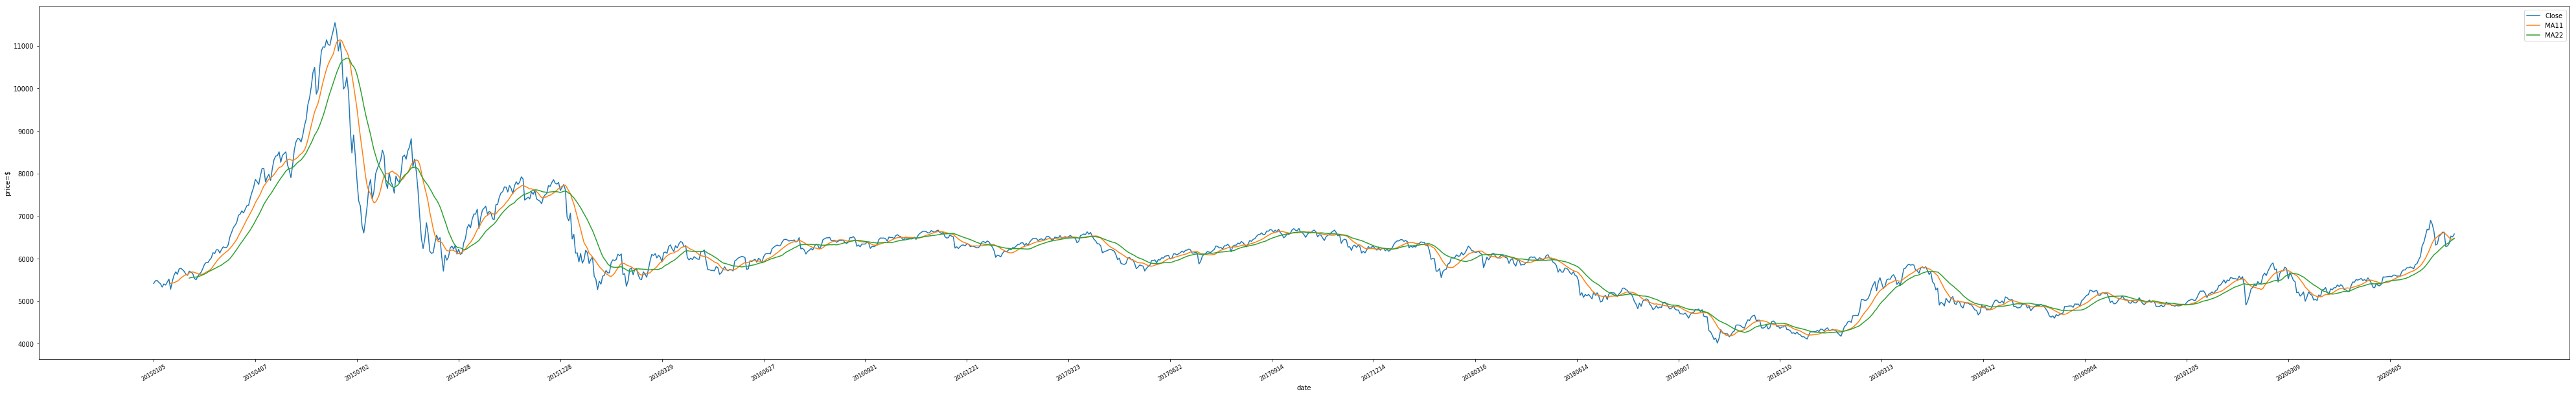

In [184]:
fig,ax=plt.subplots(figsize=(70,10))
ax.plot(time, close_price, label='Close')
ax.plot(time, short_ma, label='MA11')
ax.plot(time, long_ma, label='MA22')
ax.legend(loc='best')
ax.set_xticks(L)
ax.set_xlabel('date')
ax.set_ylabel('price=$')
plt.xticks(rotation=30,fontsize='small')
plt.show()

In [240]:
s = np.zeros(len(close_price))

is_hold = 0 # 0 - 空仓，1 - 买入，2 - 持仓，3 - 卖出

init_money = position_money = 1000000
position_amount = 0

trade_count = 0

buy_position_value = 0 # 每笔交易买入前总资金

for i in range(len(close_price)):
    trade_price = round((close_price[i] + open_price[i]) / 2, 2)
    if i == 0:
        s[0] = init_money
        continue
    if short_ma[i - 1] > long_ma[i - 1]: # 延迟一天，禁止使用未来函数
        if is_hold == 0: # 空仓买入
            is_hold = 1
            buy_position_value = position_money
            position_amount = int(position_money / trade_price)
            position_money = position_money - position_amount * trade_price
        elif is_hold == 1: # 买入持有
            is_hold = 2
        elif is_hold == 2: # 继续持有
            is_hold = 2
        elif is_hold == 3: # 卖出再次买入
            is_hold = 1
            buy_position_value = position_money
            position_amount = int(position_money / trade_price)
            position_money = position_money - position_amount * trade_price
    else:
        if is_hold == 0: # 空仓继续
            is_hold = 0
        elif is_hold == 1: # 买入卖出
            is_hold = 3
            position_money = position_money + position_amount * trade_price
            position_amount = 0
        elif is_hold == 2: # 持仓卖出
            is_hold = 3
            position_money = position_money + position_amount * trade_price
            position_amount = 0
        elif is_hold == 3: # 卖出空仓
            is_hold = 0
    
    s[i] = position_money + position_amount * close_price[i]
            
    if is_hold == 0:
        pass
    if is_hold == 1:
        print('日期: ' + str(time[i]) + ', 操作: 买入, 价格: ' + str(trade_price) + ', 持仓量: ' + str(position_amount) + ', 收盘后总资金: ' + str(round(s[i], 2)))
    if is_hold == 2:
        pass
    if is_hold == 3:
        print('日期: ' + str(time[i]) + ', 操作: 卖出, 价格: ' + str(trade_price) + ', 获利' + str(round(position_money - buy_position_value, 2)) + '(' + str(round((position_money - buy_position_value) / buy_position_value * 100, 2)) + '%)' + ', 收盘后总资金: ' + str(round(s[i], 2)))
        print('***************************************************************************************************')
        trade_count = trade_count + 1

print('###################################################################################################')
print("共交易" + str(trade_count) + "次")
print("双均线策略总收益率为: " + str(round((s[-1] - s[0]) / s[0] * 100, 2)) + '%')
print("基准(买入一直持有)的收益率为：" + str(round((close_price[-1] - close_price[0]) / close_price[0] * 100, 2)) + '%')

日期: 20150204, 操作: 买入, 价格: 5702.25, 持仓量: 175, 收盘后总资金: 996722.08
日期: 20150629, 操作: 卖出, 价格: 8875.84, 获利555378.25(55.54%), 收盘后总资金: 1555378.25
***************************************************************************************************
日期: 20150728, 操作: 买入, 价格: 7581.98, 持仓量: 205, 收盘后总资金: 1569285.43
日期: 20150811, 操作: 卖出, 价格: 8418.82, 获利171552.2(11.03%), 收盘后总资金: 1726930.45
***************************************************************************************************
日期: 20150814, 操作: 买入, 价格: 8612.51, 持仓量: 200, 收盘后总资金: 1729476.91
日期: 20150827, 操作: 卖出, 价格: 6400.5, 获利-442402.0(-25.62%), 收盘后总资金: 1284528.45
***************************************************************************************************
日期: 20151012, 操作: 买入, 价格: 6612.32, 持仓量: 194, 收盘后总资金: 1305170.46
日期: 20151208, 操作: 卖出, 价格: 7479.8, 获利168291.12(13.1%), 收盘后总资金: 1452819.57
***************************************************************************************************
日期: 20151224, 操作: 买入, 价格: 7756.71, 持仓量: 187, 收盘后

In [241]:
base_15 = np.zeros(len(close_price))

for i in range(len(close_price)):
    if i == 0:
        base_15[i] = init_money
    else:
        base_15[i] = base_15[i-1] * 1.0005592 # 设年收益为0.15，250个交易日，则每日的收益率为0.0005592

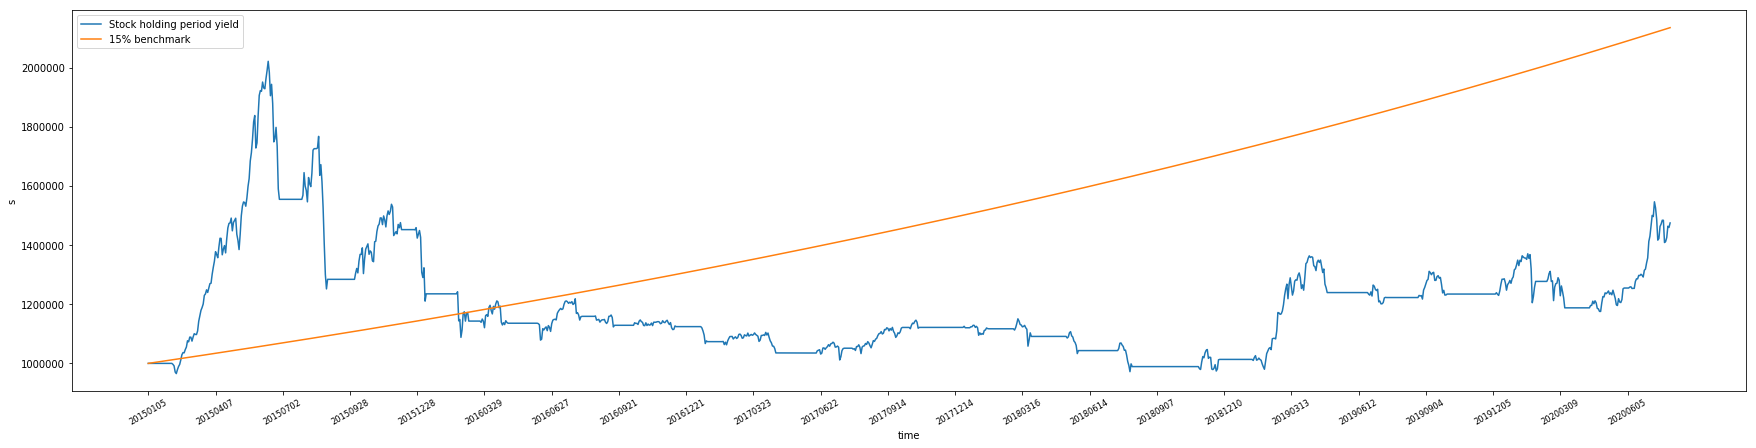

In [242]:
fig=plt.figure(figsize=(30,7))
ax=fig.add_subplot(111)
ax.plot(time,s,label='Stock holding period yield')
ax.plot(time,base_15,label='15% benchmark')
ax.legend(loc='best')
ax.set_xlabel('time')
ax.set_ylabel('s')
ax.set_xticks(L)
plt.xticks(rotation=30,fontsize='small')
plt.show()